# Plot physical fields for context

Including sea ice freezing (SOSE), Ekman velocity from surface stress, and EKE

### Import packages

In [1]:
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib as mpl
import matplotlib.patches as mpatches
import pandas as pd
from sklearn import manifold
import seaborn as sns
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo
import cmocean
from xhistogram.xarray import histogram
### os tools
import os.path
from glob import glob
import load_and_preprocess as lp
import file_io as io
import density
import random
import gsw

# Sea ice freezing line

### Read in sea ice freezing data (created from SOSE data in Matlab)

In [2]:
# load winter sea ice freezing maps
dp = io.load_sose_SIfreeze(file_name="physical_fields/SIfreeze_SOSE.nc")

# show contents
dp

<xarray.Dataset>
Dimensions:   (lon: 2160, lat: 198)
Coordinates:
  * lon       (lon) float64 -179.9 -179.8 -179.6 -179.4 ... 179.6 179.8 179.9
  * lat       (lat) float64 -77.87 -77.71 -77.54 -77.37 ... -45.37 -45.21 -45.04
Data variables:
    SIfreeze  (lat, lon) float64 ...
Attributes:
    Source:       SOSE iteration 100, 2005-2010
    Source URL:   http://sose.ucsd.edu/sose_stateestimation_data_05to10.html
    Description:  JAS (Austral winter) average 2005-2010

In [3]:
# show contents of SIfreeze variable 
dp.SIfreeze

<xarray.DataArray 'SIfreeze' (lat: 198, lon: 2160)>
[427680 values with dtype=float64]
Coordinates:
  * lon      (lon) float64 -179.9 -179.8 -179.6 -179.4 ... 179.6 179.8 179.9
  * lat      (lat) float64 -77.87 -77.71 -77.54 -77.37 ... -45.37 -45.21 -45.04
Attributes:
    Units:          [kg/m^2/s]
    Long name:      Seaice package: Ocean surface freshwater flux
    Variable name:  SIfreeze
    Threshold:      1e-05
    Convention:     > 0 increases salt

In [4]:
# load fronts
pf = io.load_front("fronts/pf_kim.txt")
saccf = io.load_front("fronts/saccf_kim.txt")
saf = io.load_front("fronts/saf_kim.txt")
sbdy = io.load_front("fronts/sbdy_kim.txt")

In [5]:
# select geographic extent of the plot (keep consistent for all plots in this notebook)
lon_min = -65
lon_max =  80
lat_min = -80
lat_max = -45

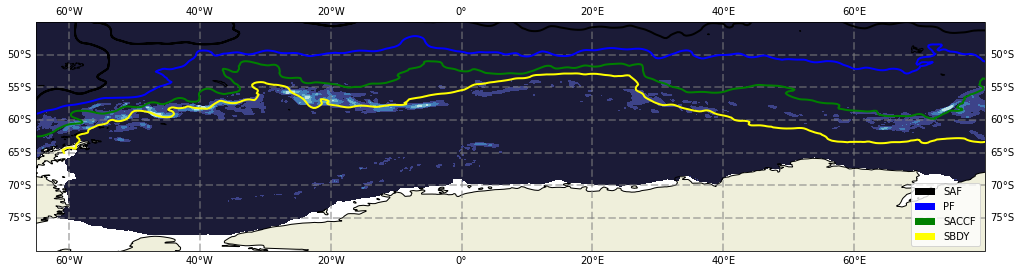

In [6]:
# make plot
plt.figure(figsize=(17, 13))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], ccrs.PlateCarree())

# contour plot of sea ice freezing
h = ax.contourf(dp.lon, dp.lat, dp.SIfreeze,
                levels=[0.0, 2e-5, 4e-5, 6e-5, 8e-5, 10e-5],
                transform=ccrs.PlateCarree(), vmin=0.0, vmax=10e-5,
                cmap=cmocean.cm.ice)

# fronts
h_saf = plt.plot(saf[:,0], saf[:,1], color="black", linewidth=2.0, transform=ccrs.Geodetic())
h_pf = plt.plot(pf[:,0], pf[:,1], color="blue", linewidth=2.0, transform=ccrs.Geodetic())
h_saccf = plt.plot(saccf[:,0], saccf[:,1], color="green", linewidth=2.0, transform=ccrs.Geodetic())
h_sbdy = plt.plot(sbdy[:,0], sbdy[:,1], color="yellow", linewidth=2.0, transform=ccrs.Geodetic())
ax.coastlines(resolution='50m')
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
             linewidth=2, color='gray', alpha=0.5, linestyle='--')
ax.add_feature(cartopy.feature.LAND)

# make two proxy artists to add to a legend
l_saf = mpatches.Rectangle((0, 0), 1, 1, facecolor="black")
l_pf = mpatches.Rectangle((0, 0), 1, 1, facecolor="blue")
l_saccf = mpatches.Rectangle((0, 0), 1, 1, facecolor="green")
l_sbdy = mpatches.Rectangle((0, 0), 1, 1, facecolor="yellow")
labels = ['SAF', 'PF', 'SACCF', 'SBDY']
plt.legend([l_saf, l_pf, l_saccf, l_sbdy], labels,
           loc='lower right', fancybox=True)

# save figure
plt.savefig("physical_fields/SeaIceFreezing_SOSE_winter.png", bbox_inches="tight")
plt.savefig("physical_fields/SeaIceFreezing_SOSE_winter.pdf", bbox_inches="tight")
plt.show()
plt.close()

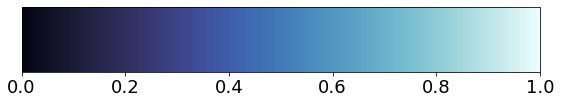

In [7]:
# separate colorbar
a = np.array([[0.0, 1.0]])    # 1e-4
plt.figure(figsize=(9, 1.5))
img = plt.imshow(a, cmap=cmocean.cm.ice)
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
cbar = plt.colorbar(orientation="horizontal", cax=cax)
cbar.ax.tick_params(labelsize=18)
plt.savefig('physical_fields/hist_colorbar.pdf', bbox_inches='tight')
plt.savefig('physical_fields/hist_colorbar.png', bbox_inches='tight')
plt.show()
plt.close()

# Ekman velocity from surface stress

In [8]:
ds = lp.load_ekman_vel()
we = ds.we_oss.mean("time",skipna=True)

load_and_preprocess.load_ekman_vel


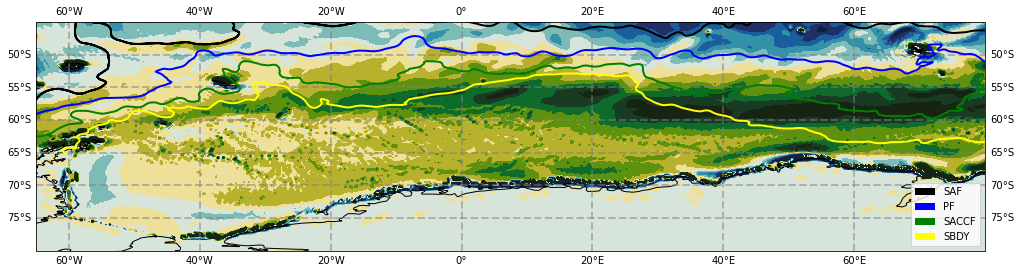

In [9]:
# make plot
plt.figure(figsize=(17, 13))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], ccrs.PlateCarree())

# contour plot of sea ice freezing
h = ax.contourf(we.longitude, we.latitude, we,
                levels=[-100, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 100],
                transform=ccrs.PlateCarree(), vmin=-10, vmax=10,
                cmap=cmocean.cm.delta)

# fronts
h_saf = plt.plot(saf[:,0], saf[:,1], color="black", linewidth=2.0, transform=ccrs.Geodetic())
h_pf = plt.plot(pf[:,0], pf[:,1], color="blue", linewidth=2.0, transform=ccrs.Geodetic())
h_saccf = plt.plot(saccf[:,0], saccf[:,1], color="green", linewidth=2.0, transform=ccrs.Geodetic())
h_sbdy = plt.plot(sbdy[:,0], sbdy[:,1], color="yellow", linewidth=2.0, transform=ccrs.Geodetic())
ax.coastlines(resolution='50m')
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
             linewidth=2, color='gray', alpha=0.5, linestyle='--')
ax.add_feature(cartopy.feature.LAND)

# make two proxy artists to add to a legend
l_saf = mpatches.Rectangle((0, 0), 1, 1, facecolor="black")
l_pf = mpatches.Rectangle((0, 0), 1, 1, facecolor="blue")
l_saccf = mpatches.Rectangle((0, 0), 1, 1, facecolor="green")
l_sbdy = mpatches.Rectangle((0, 0), 1, 1, facecolor="yellow")
labels = ['SAF', 'PF', 'SACCF', 'SBDY']
plt.legend([l_saf, l_pf, l_saccf, l_sbdy], labels,
           loc='lower right', fancybox=True)

# save figure
plt.savefig("physical_fields/ekman_velocity_oss.png", bbox_inches="tight")
plt.savefig("physical_fields/ekman_velocity_oss.pdf", bbox_inches="tight")
plt.show()
plt.close()

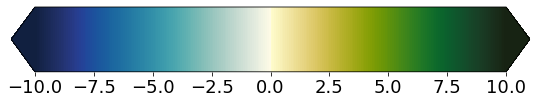

In [10]:
# separate colorbar
a = np.array([[-10, 10]])    # 1e-4
plt.figure(figsize=(9, 1.5))
img = plt.imshow(a, cmap=cmocean.cm.delta)
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
cbar = plt.colorbar(orientation="horizontal", cax=cax, extend="both")
cbar.ax.tick_params(labelsize=18)
plt.savefig('physical_fields/wek_colorbar.pdf', bbox_inches='tight')
plt.savefig('physical_fields/wek_colorbar.png', bbox_inches='tight')
plt.show()
plt.close()

# Eddy kinetic energy (EKE)

In [11]:
ds = lp.load_eke_and_geo()
eke = ds.eke

load_and_preprocess.load_eke_and_geo


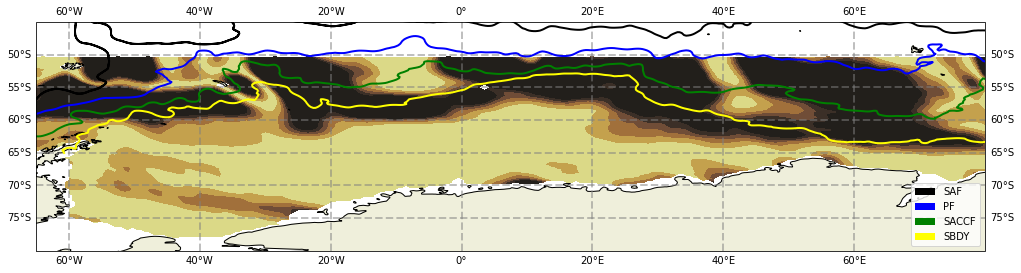

In [12]:
# make plot
plt.figure(figsize=(17, 13))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], ccrs.PlateCarree())

# contour plot of sea ice freezing
h = ax.contourf(eke.longitude, eke.latitude, eke,
                levels=[0.000, 0.0002, 0.0004, 0.0006, 0.0008, 0.0010, 0.1],
                transform=ccrs.PlateCarree(), vmin=0, vmax=0.0010,
                cmap=cmocean.cm.turbid)

# fronts
h_saf = plt.plot(saf[:,0], saf[:,1], color="black", linewidth=2.0, transform=ccrs.Geodetic())
h_pf = plt.plot(pf[:,0], pf[:,1], color="blue", linewidth=2.0, transform=ccrs.Geodetic())
h_saccf = plt.plot(saccf[:,0], saccf[:,1], color="green", linewidth=2.0, transform=ccrs.Geodetic())
h_sbdy = plt.plot(sbdy[:,0], sbdy[:,1], color="yellow", linewidth=2.0, transform=ccrs.Geodetic())
ax.coastlines(resolution='50m')
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
             linewidth=2, color='gray', alpha=0.5, linestyle='--')
ax.add_feature(cartopy.feature.LAND)

# make two proxy artists to add to a legend
l_saf = mpatches.Rectangle((0, 0), 1, 1, facecolor="black")
l_pf = mpatches.Rectangle((0, 0), 1, 1, facecolor="blue")
l_saccf = mpatches.Rectangle((0, 0), 1, 1, facecolor="green")
l_sbdy = mpatches.Rectangle((0, 0), 1, 1, facecolor="yellow")
labels = ['SAF', 'PF', 'SACCF', 'SBDY']
plt.legend([l_saf, l_pf, l_saccf, l_sbdy], labels,
           loc='lower right', fancybox=True)

# save figure
plt.savefig("physical_fields/eke_clim.png", bbox_inches="tight")
plt.savefig("physical_fields/eke_clim.pdf", bbox_inches="tight")
plt.show()
plt.close()

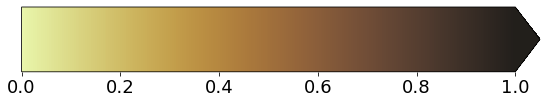

In [13]:
# separate colorbar
a = np.array([[0, 1.0]])  # 1e-3    
plt.figure(figsize=(9, 1.5))
img = plt.imshow(a, cmap=cmocean.cm.turbid)
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
cbar = plt.colorbar(orientation="horizontal", cax=cax, extend="max")
cbar.ax.tick_params(labelsize=18)
plt.savefig('physical_fields/eke_colorbar.pdf', bbox_inches='tight')
plt.savefig('physical_fields/eke_colorbar.png', bbox_inches='tight')
plt.show()
plt.close()

# Geostrophic velocity 

In [14]:
u_g = ds.u_g
v_g = ds.v_g

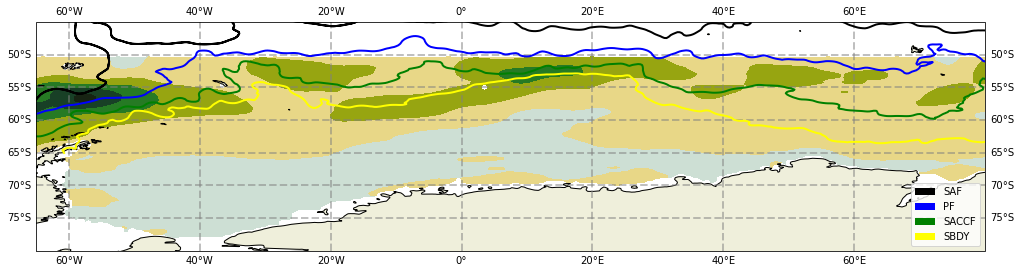

In [15]:
# make plot
plt.figure(figsize=(17, 13))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], ccrs.PlateCarree())

# contour plot of sea ice freezing
h = ax.contourf(u_g.longitude, u_g.latitude, u_g,
                levels=[-0.25, -0.20, -0.15, -0.10, -0.05, 0.00, 0.05, 0.10, 0.15, 0.20, 0.25],
                transform=ccrs.PlateCarree(), vmin=-0.20, vmax=0.20,
                cmap=cmocean.cm.delta)

# fronts
h_saf = plt.plot(saf[:,0], saf[:,1], color="black", linewidth=2.0, transform=ccrs.Geodetic())
h_pf = plt.plot(pf[:,0], pf[:,1], color="blue", linewidth=2.0, transform=ccrs.Geodetic())
h_saccf = plt.plot(saccf[:,0], saccf[:,1], color="green", linewidth=2.0, transform=ccrs.Geodetic())
h_sbdy = plt.plot(sbdy[:,0], sbdy[:,1], color="yellow", linewidth=2.0, transform=ccrs.Geodetic())
ax.coastlines(resolution='50m')
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
             linewidth=2, color='gray', alpha=0.5, linestyle='--')
ax.add_feature(cartopy.feature.LAND)

# make two proxy artists to add to a legend
l_saf = mpatches.Rectangle((0, 0), 1, 1, facecolor="black")
l_pf = mpatches.Rectangle((0, 0), 1, 1, facecolor="blue")
l_saccf = mpatches.Rectangle((0, 0), 1, 1, facecolor="green")
l_sbdy = mpatches.Rectangle((0, 0), 1, 1, facecolor="yellow")
labels = ['SAF', 'PF', 'SACCF', 'SBDY']
plt.legend([l_saf, l_pf, l_saccf, l_sbdy], labels,
           loc='lower right', fancybox=True)

# save figure
plt.savefig("physical_fields/ug_clim.png", bbox_inches="tight")
plt.savefig("physical_fields/ug_clim.pdf", bbox_inches="tight")
plt.show()
plt.close()

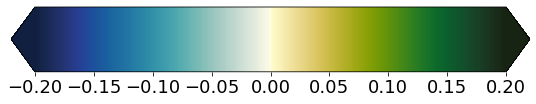

In [16]:
# separate colorbar
a = np.array([[-0.20, 0.20]])      
plt.figure(figsize=(9, 1.5))
img = plt.imshow(a, cmap=cmocean.cm.delta)
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
cbar = plt.colorbar(orientation="horizontal", cax=cax, extend="both")
cbar.ax.tick_params(labelsize=18)
plt.savefig('physical_fields/ug_colorbar.pdf', bbox_inches='tight')
plt.savefig('physical_fields/ug_colorbar.png', bbox_inches='tight')
plt.show()
plt.close()

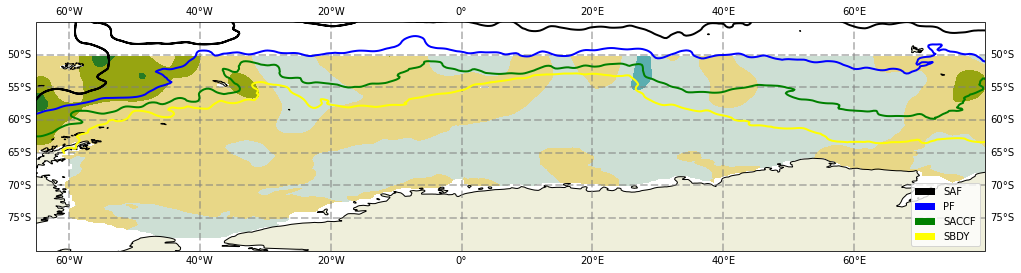

In [17]:
# make plot
plt.figure(figsize=(17, 13))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], ccrs.PlateCarree())

# contour plot of sea ice freezing
h = ax.contourf(v_g.longitude, v_g.latitude, v_g,
                levels=[-0.25, -0.20, -0.15, -0.10, -0.05, 0.00, 0.05, 0.10, 0.15, 0.20, 0.25],
                transform=ccrs.PlateCarree(), vmin=-0.20, vmax=0.20,
                cmap=cmocean.cm.delta)

# fronts
h_saf = plt.plot(saf[:,0], saf[:,1], color="black", linewidth=2.0, transform=ccrs.Geodetic())
h_pf = plt.plot(pf[:,0], pf[:,1], color="blue", linewidth=2.0, transform=ccrs.Geodetic())
h_saccf = plt.plot(saccf[:,0], saccf[:,1], color="green", linewidth=2.0, transform=ccrs.Geodetic())
h_sbdy = plt.plot(sbdy[:,0], sbdy[:,1], color="yellow", linewidth=2.0, transform=ccrs.Geodetic())
ax.coastlines(resolution='50m')
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
             linewidth=2, color='gray', alpha=0.5, linestyle='--')
ax.add_feature(cartopy.feature.LAND)

# make two proxy artists to add to a legend
l_saf = mpatches.Rectangle((0, 0), 1, 1, facecolor="black")
l_pf = mpatches.Rectangle((0, 0), 1, 1, facecolor="blue")
l_saccf = mpatches.Rectangle((0, 0), 1, 1, facecolor="green")
l_sbdy = mpatches.Rectangle((0, 0), 1, 1, facecolor="yellow")
labels = ['SAF', 'PF', 'SACCF', 'SBDY']
plt.legend([l_saf, l_pf, l_saccf, l_sbdy], labels,
           loc='lower right', fancybox=True)

# save figure
plt.savefig("physical_fields/vg_clim.png", bbox_inches="tight")
plt.savefig("physical_fields/vg_clim.pdf", bbox_inches="tight")
plt.show()
plt.close()

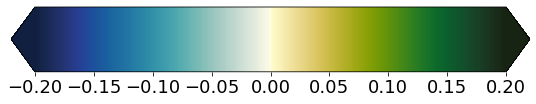

In [18]:
# separate colorbar
a = np.array([[-0.20, 0.20]])      
plt.figure(figsize=(9, 1.5))
img = plt.imshow(a, cmap=cmocean.cm.delta)
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
cbar = plt.colorbar(orientation="horizontal", cax=cax, extend="both")
cbar.ax.tick_params(labelsize=18)
plt.savefig('physical_fields/ug_colorbar.pdf', bbox_inches='tight')
plt.savefig('physical_fields/ug_colorbar.png', bbox_inches='tight')
plt.show()
plt.close()